* Refrence
* https://arxiv.org/abs/1610.02391?context=cs.AI
* https://github.com/ramprs/grad-cam
* https://keras.io/examples/vision/grad_cam/

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import tensorflow as tf
import cv2

from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.models import *

*   img_size = Model input size
*   last_conv_layer_name can be found using model.summary() and look for name of last convolutional layer




In [ ]:
img_size = (224, 224)
img_path = '/content/gdrive/MyDrive/model/11_oc.jpg'
model_path = "/content/gdrive/MyDrive/final/dataset/VGG19_v02_d170822.h5"

last_conv_layer_name = 'block5_conv3'
thresh = 0.5

*   Visualize CNN class activation 



In [ ]:
def model_visualization_gradCAM(img_path, last_conv_layer_name, thresh, model_path, pred_index=None, emphasize=False):
  # First, create a model that maps the input image to the activations of the last conv layer as well as the output predictions

  img = cv2.imread(img_path, cv2.COLOR_RGB2BGR)
  img_super = cv2.resize(img, img_size, interpolation = cv2.INTER_AREA)
  img_grad = np.expand_dims(img_super, axis=0)

  model = load_model(model_path, compile=True)

  # Remove last layer's softmax
  model.layers[-1].activation = None

  #Print what the top predicted class is
  preds = model.predict(img_grad)
  print("model_class_prediction:", np.argmax(preds))



  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, compute the gradient of the top predicted class for input image with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_grad)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # For visualization purpose, normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  cam = heatmap.numpy()
  heatmap_s = cv2.resize(cam, (img_super.shape[1], img_super.shape[0]))
  if emphasize:
      heatmap_s = 1 / (1 + np.exp(-50 * (heatmap_s-thresh)))
  heatmap_s = np.uint8(255 * heatmap_s)
  heatmap_s = cv2.applyColorMap(heatmap_s, cv2.COLORMAP_JET)

  hif = .8
  superimposed_img = heatmap_s * hif + img_super
  superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
  superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

  # Visualize original and superimposed image
  plt.figure(figsize=(12, 5))
  ax = plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(img_super, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title('Original Image')
  ax = plt.subplot(1, 2, 2)
  plt.imshow(superimposed_img_rgb)
  plt.axis('off')
  plt.title(str(last_conv_layer_name) + ' Grad-CAM heat-map')
  plt.tight_layout()

  return superimposed_img_rgb

1/1 [==============================] - 1s 816ms/step
model_class_prediction: 1


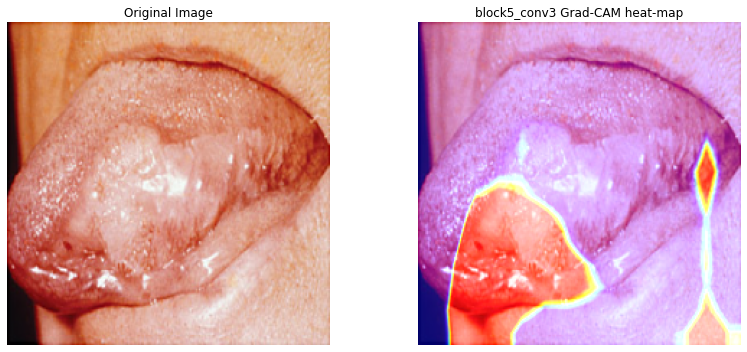

In [ ]:
CAM = model_visualization_gradCAM(img_path, last_conv_layer_name, thresh, model_path, emphasize=True)